In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

## Read Data For WA, NY, TX, CA and from 2018 to 2022

In [2]:
# Navigate up one level from the current directory
parent_dir = os.path.dirname(os.getcwd())

# Define the relative path to the Parquet file from the parent directory
relative_path = r"analyticsDF.parquet"

# Concatenate the parent directory path and the relative path to get the full path
full_path = os.path.join(parent_dir, relative_path)

In [3]:
df = pd.read_parquet(full_path)

In [4]:
df.info(verbose = True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9712778 entries, 0 to 9712777
Data columns (total 70 columns):
 #   Column                             Non-Null Count    Dtype  
---  ------                             --------------    -----  
 0   activity_year                      9712778 non-null  object 
 1   lei                                9712778 non-null  object 
 2   derived_msa_md                     9712778 non-null  object 
 3   state_code                         9712778 non-null  object 
 4   county_code                        9712778 non-null  object 
 5   census_tract                       9712778 non-null  object 
 6   conforming_loan_limit              9712778 non-null  object 
 7   derived_loan_product_type          9712778 non-null  object 
 8   derived_dwelling_category          9712778 non-null  object 
 9   derived_ethnicity                  9712778 non-null  object 
 10  derived_race                       9712778 non-null  object 
 11  derived_sex             

In [5]:
# size of dataset
len(df)

9712778

## Drop rows due to inconclusive dependent variable

In [6]:
# Values:

#     1 - 1 Loan originated
#     2 - 1 Application approved but not accepted
#     3 - 0 Application denied
#     4 - *drop* Application withdrawn by applicant
#     5 - *drop* File closed for incompleteness
#     6 - 1 Purchased loan
#     7 - 0 Preapproval request denied
#     8 - 1 Preapproval request approved but not accepted

selected = df.loc[:, 'action_taken'].isin(['4', '5'])
df = df[~selected]
len(df)

8211413

In [7]:
# Create dependate binary variable

accepted_selected = df.loc[:, 'action_taken'].isin(['1', '2', '6', '8'])
df.loc[:, 'application_approved'] = 0  # Default value is 0

# Update rows where accepted_selected is True
df.loc[accepted_selected, 'application_approved'] = 1

## Cleaning Features

In [8]:
#conbination of race and ethinicty to no leave out hispanic or latino

df['race_ethnicity'] = df['derived_race'].str.cat(df['derived_ethnicity'], sep='|')

# how many categroies were created
len(df.race_ethnicity.value_counts(dropna=False))

45

In [9]:
df.applicant_age.value_counts()

25-34    2207964
35-44    2067634
45-54    1286557
-99      1134923
55-64     781714
65-74     344005
<25       300211
>74        88398
9999           7
Name: applicant_age, dtype: int64

### Keep Columns of Interest

In [10]:
# Keep columns of interest
df = df.loc[:, ['application_approved', 'race_ethnicity','county_code', 'derived_sex', 'income', 'applicant_age', 'loan_amount', 'property_value', 'loan_term', 'interest_rate', 'state_code', 'activity_year', 'occupancy_type']]

In [11]:
# Filtering rows with NaN values in any column
df = df[~df.isna().any(axis=1)]
# size of dataset
len(df)

6134535

In [12]:
df.columns

Index(['application_approved', 'race_ethnicity', 'county_code', 'derived_sex',
       'income', 'applicant_age', 'loan_amount', 'property_value', 'loan_term',
       'interest_rate', 'state_code', 'activity_year', 'occupancy_type'],
      dtype='object')

In [13]:
# Remove negative ammounts
df = df[df.loc[:,'income']>0]

df = df[df.loc[:,'property_value']>0]
df = df[df['interest_rate']>0]

df = df[df['loan_term']>0]
#Normalized Income

# Apply log transformation using numpy's log1p function
df['income_log'] = np.log1p(df['income'])

# Convert the 'loan_amount' column to float64
df['loan_amount'] = df['loan_amount'].astype('float64')

# Apply log transformation using numpy's log1p function
df['loan_amount_log'] = np.log1p(df['loan_amount'])

# Convert the 'loan_amount' column to float64
df['property_value'] = df['property_value'].astype('float64')

# Apply log transformation using numpy's log1p function
df['property_value_log'] = np.log1p(df['property_value'])

df['interest_rate'] = df['interest_rate'].astype('float64')

df['loan_term'] = df['loan_term'].astype('float64')


df['loan_to_value'] = df['loan_amount'] / df['property_value'] 

df['debt_to_income'] = df['loan_amount'] / df['income'] 

#df.drop(['income', 'loan_amount', 'property_value'], axis=1, inplace=True) 

# size of dataset
len(df)

5949706

In [14]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
application_approved,5949706.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00
income,5949706.0,569.908027,9434.538715,1.000000,73.000000,110.000000,171.000000,1.197064e+07
loan_amount,5949706.0,410365.150816,446790.592685,5000.000000,215000.000000,325000.000000,495000.000000,5.250050e+08
property_value,5949706.0,528470.337862,625066.008273,5000.000000,255000.000000,385000.000000,615000.000000,5.300050e+08
loan_term,5949706.0,349.804881,41.540383,1.000000,360.000000,360.000000,360.000000,3.360000e+03
interest_rate,5949706.0,4.167932,27.512630,0.001000,3.125000,3.875000,4.750000,4.387500e+04
income_log,5949706.0,4.789633,0.813742,0.693147,4.304065,4.709530,5.147494,1.629797e+01
loan_amount_log,5949706.0,12.672197,0.728853,8.517393,12.278398,12.691584,13.112315,2.007892e+01
property_value_log,5949706.0,12.898053,0.716119,8.517393,12.449023,12.861001,13.329379,2.008840e+01
loan_to_value,5949706.0,0.832514,0.401449,0.000737,0.771429,0.859649,0.957895,3.608282e+02


In [15]:
def plot_distribution(df):
    """Plot distribution charts for all float columns in the DataFrame.

    Args:
        df (pandas DataFrame): Input DataFrame
    """
    import matplotlib.pyplot as plt
    # Select only float columns
    float_cols = df.select_dtypes(include=['float'])

    # Plot distribution for each float column
    for col in float_cols.columns:
        plt.figure(figsize=(8, 6))
        # Calculate number of bins dynamically
        min_val = df[col].min()
        max_val = df[col].max()
        num_bins = min(10, max_val - min_val)  # Limiting to 20 bins or the range of the data
        plt.hist(df[col], bins=num_bins, range=(min_val, max_val), color='skyblue', edgecolor='black')
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.show()


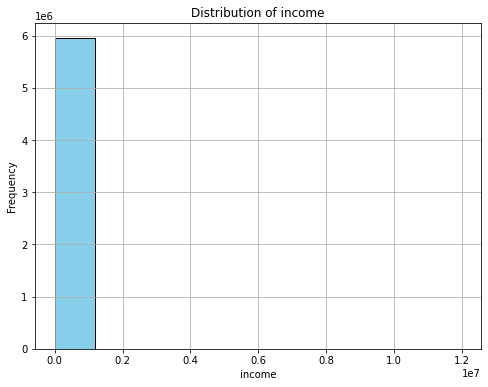

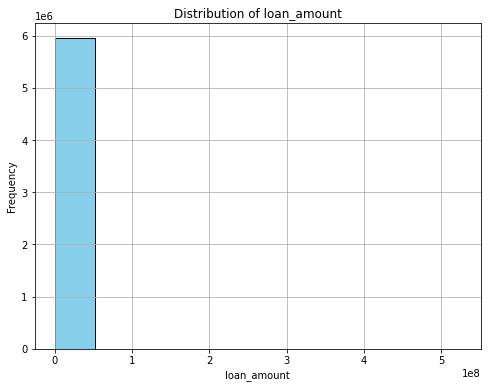

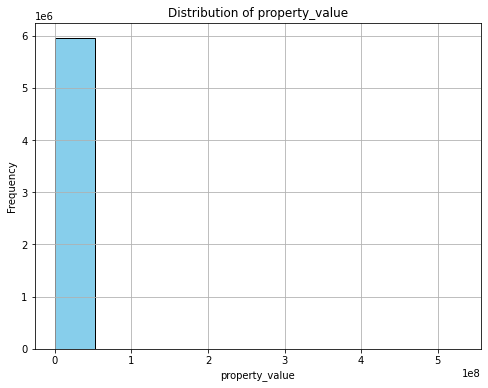

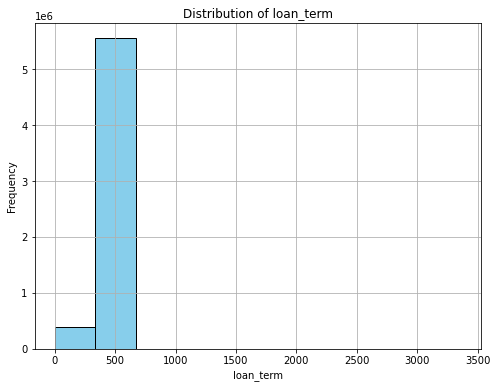

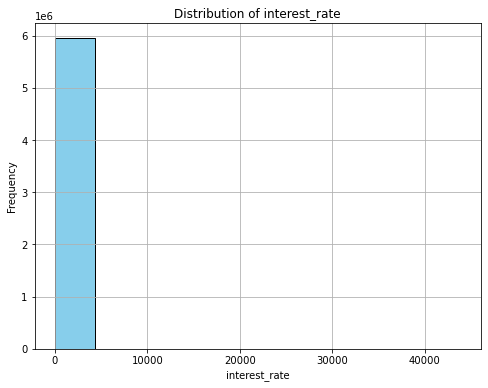

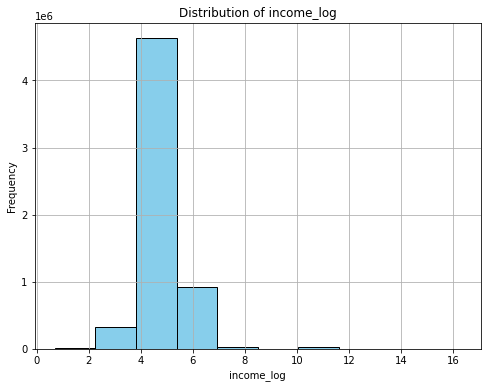

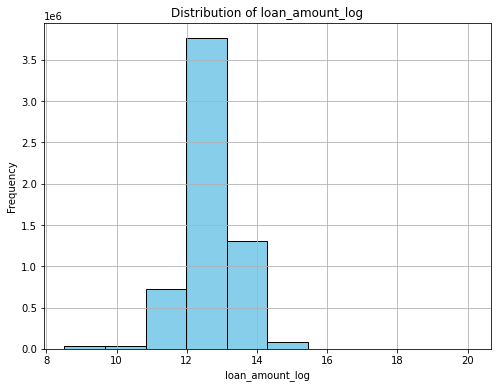

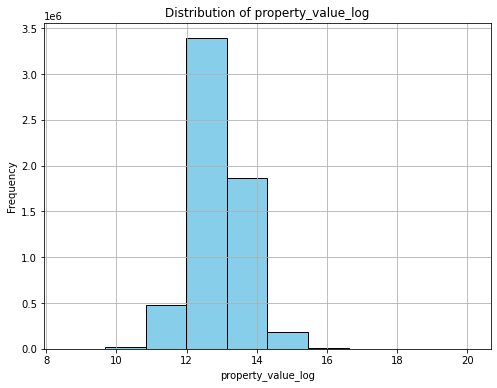

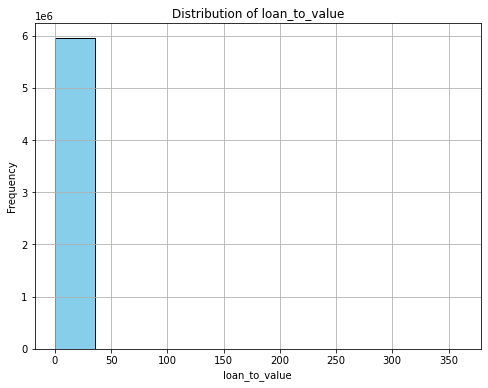

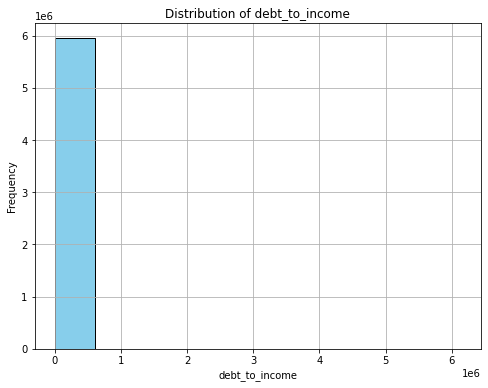

In [16]:
plot_distribution(df)

In [17]:

data_encoded = pd.get_dummies(df, columns=['race_ethnicity', 'state_code', 'activity_year' ,'occupancy_type','county_code', 'derived_sex','applicant_age' ], drop_first=True)


In [20]:
data_encoded_ref = pd.get_dummies(df, columns=['race_ethnicity', 'state_code', 'activity_year' ,'occupancy_type','county_code', 'derived_sex','applicant_age' ], drop_first=False)

In [18]:
len(data_encoded.columns)

544

In [19]:
data_encoded.columns

Index(['application_approved', 'income', 'loan_amount', 'property_value',
       'loan_term', 'interest_rate', 'income_log', 'loan_amount_log',
       'property_value_log', 'loan_to_value',
       ...
       'derived_sex_Male', 'derived_sex_Sex Not Available',
       'applicant_age_25-34', 'applicant_age_35-44', 'applicant_age_45-54',
       'applicant_age_55-64', 'applicant_age_65-74', 'applicant_age_9999',
       'applicant_age_<25', 'applicant_age_>74'],
      dtype='object', length=544)

In [21]:
data_encoded_ref.columns

Index(['application_approved', 'income', 'loan_amount', 'property_value',
       'loan_term', 'interest_rate', 'income_log', 'loan_amount_log',
       'property_value_log', 'loan_to_value',
       ...
       'derived_sex_Sex Not Available', 'applicant_age_-99',
       'applicant_age_25-34', 'applicant_age_35-44', 'applicant_age_45-54',
       'applicant_age_55-64', 'applicant_age_65-74', 'applicant_age_9999',
       'applicant_age_<25', 'applicant_age_>74'],
      dtype='object', length=551)

In [22]:
# Reference Columns
columns_only_in_df1 = data_encoded_ref.columns.difference(data_encoded.columns)
columns_only_in_df1

Index(['activity_year_2018', 'applicant_age_-99', 'county_code_00170',
       'derived_sex_Female', 'occupancy_type_Investment',
       'race_ethnicity_2 or more minority races|Ethnicity Not Available',
       'state_code_CA'],
      dtype='object')

In [25]:
df.to_parquet(parent_dir + "\df_small.parquet")
data_encoded.to_parquet(parent_dir + "\df_small_encoded.parquet")